In [2]:
import pandas as pd
import sklearn as skl
import matplotlib.pyplot as plt
import numpy as np
import scipy
from numpy import linalg as LA

from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from time import process_time
from sklearn.linear_model import LogisticRegression
from sklearn_rvm import EMRVC

# Подход 1: градиентный бустинг "в лоб"

In [3]:
# Считайте таблицу с признаками из файла features.csv с помощью кода, приведенного выше. 
# Удалите признаки, связанные с итогами матча (они помечены в описании данных как отсутствующие в тестовой выборке).

drop = ['duration',
    'radiant_win',
    'tower_status_radiant',
    'tower_status_dire',
    'barracks_status_dire',
    'barracks_status_radiant']

tar = 'radiant_win'

data = pd.read_csv('./features.csv', index_col='match_id')
features = data.drop(labels=drop, axis = 1)

In [4]:
# Проверьте выборку на наличие пропусков с помощью функции count(), которая для каждого столбца показывает число заполненных значений. 
# Много ли пропусков в данных? 
# Запишите названия признаков, имеющих пропуски, и попробуйте для любых двух из них дать обоснование, почему их значения могут быть пропущены.

# Если событие "first_blood" не успело произойти за первые 5 минут, то признаки принимают пропущенное значение

missing_features = features.columns[(features.count()<97230).values]

features.count()[missing_features]

first_blood_time               77677
first_blood_team               77677
first_blood_player1            77677
first_blood_player2            53243
radiant_bottle_time            81539
radiant_courier_time           96538
radiant_flying_courier_time    69751
radiant_first_ward_time        95394
dire_bottle_time               81087
dire_courier_time              96554
dire_flying_courier_time       71132
dire_first_ward_time           95404
dtype: int64

In [5]:
# Замените пропуски на нули с помощью функции fillna(). 
# На самом деле этот способ является предпочтительным для логистической регрессии, поскольку он позволит пропущенному значению не вносить никакого вклада в предсказание. 
# Для деревьев часто лучшим вариантом оказывается замена пропуска на очень большое или очень маленькое значение — в этом случае при построении разбиения вершины можно будет отправить объекты с пропусками в отдельную ветвь дерева. 
# Также есть и другие подходы — например, замена пропуска на среднее значение признака. 
# Мы не требуем этого в задании, но при желании попробуйте разные подходы к обработке пропусков и сравните их между собой.
inf = 10e20
features = features.fillna(inf)
features.columns[(features.count()<97230).values]

Index([], dtype='object')

In [6]:
# Какой столбец содержит целевую переменную? Запишите его название.

target = data[tar]
target.value_counts()

1    50414
0    46816
Name: radiant_win, dtype: int64

In [7]:
# Забудем, что в выборке есть категориальные признаки, и попробуем обучить градиентный бустинг над деревьями на имеющейся матрице "объекты-признаки". 
# Зафиксируйте генератор разбиений для кросс-валидации по 5 блокам (KFold), не забудьте перемешать при этом выборку (shuffle=True), 
# поскольку данные в таблице отсортированы по времени, и без перемешивания можно столкнуться с нежелательными эффектами при оценивании качества. 
# Оцените качество градиентного бустинга (GradientBoostingClassifier) с помощью данной кросс-валидации, 
# попробуйте при этом разное количество деревьев (как минимум протестируйте следующие значения для количества деревьев: 10, 20, 30). 
# Долго ли настраивались классификаторы? 

# ??? Достигнут ли оптимум на испытанных значениях параметра n_estimators, или же качество, скорее всего, продолжит расти при дальнейшем его увеличении ???
# Fitting the training set too closely can lead to degradation of the model's generalization ability. 
# Several so-called regularization techniques reduce this overfitting effect by constraining the fitting procedure.

# One natural regularization parameter is the number of gradient boosting iterations M 
# (i.e. the number of trees in the model when the base learner is a decision tree). 
# Increasing M reduces the error on training set, but setting it too high may lead to overfitting. 
# An optimal value of M is often selected by monitoring prediction error on a separate validation data set. 
# Besides controlling M, several other regularization techniques are used.

# Another regularization parameter is the depth of the trees. 
# The higher this value the more likely the model will overfit the training data.

def crossV_gb(n, X, y):
        kf = KFold(n_splits=5, random_state=1, shuffle=True)
        start = process_time()
        print(n)
        gbc = GradientBoostingClassifier(n_estimators=n, verbose=True, random_state=241, learning_rate=0.2)
        cvs = cross_val_score(gbc, X, y, cv=kf, scoring='roc_auc').mean()
        end = process_time()
        t = end - start
        return cvs, t

n_est = [10, 20, 30, 40]
cvs = np.zeros(4)
t = np.zeros(4)

# Подход 2: логистическая регрессия


Линейные методы работают гораздо быстрее композиций деревьев, поэтому кажется разумным воспользоваться именно ими для ускорения анализа данных. Одним из наиболее распространенных методов для классификации является логистическая регрессия.

Важно: не забывайте, что линейные алгоритмы чувствительны к масштабу признаков! Может пригодиться sklearn.preprocessing.StandartScaler.

In [8]:
# 1. Оцените качество логистической регрессии (sklearn.linear_model.LogisticRegression с L2-регуляризацией) 
# с помощью кросс-валидации по той же схеме, которая использовалась для градиентного бустинга. 
# Подберите при этом лучший параметр регуляризации (C). 
# Какое наилучшее качество у вас получилось? 
# Как оно соотносится с качеством градиентного бустинга? 

# Чем вы можете объяснить эту разницу? 
# Быстрее ли работает логистическая регрессия по сравнению с градиентным бустингом?

# 2. Среди признаков в выборке есть категориальные, которые мы использовали как числовые, что вряд ли является хорошей идеей. 
# Категориальных признаков в этой задаче одиннадцать: 
# lobby_type и r1_hero, r2_hero, ..., r5_hero, d1_hero, d2_hero, ..., d5_hero. 
# Уберите их из выборки, и проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 
# Изменилось ли качество? Чем вы можете это объяснить?

def crossV_log(features, target, C):
    cc = C
    cvs = np.zeros((len(cc), 8))
    t = np.zeros(len(cc))
    i=0
    kf = KFold(n_splits=8, shuffle=True, random_state=241)
    for c in cc:
        print(c)
        start = process_time()
        logreg = LogisticRegression(penalty='l2', C = c, tol=1e-4)
        cvs[i] = cross_val_score(logreg, features, target, cv=kf, scoring = 'roc_auc').mean()
        end = process_time()
        t[i] = end - start
        i+=1
    return cvs, t

drop_categorical = [
    'lobby_type',
    'r1_hero',
    'r2_hero',
    'r3_hero',
    'r4_hero',
    'r5_hero',
    'd1_hero',
    'd2_hero',
    'd3_hero',
    'd4_hero',
    'd5_hero'
]

features2 = features.drop(labels = drop_categorical, axis = 1)
cc = [1, 10, 100, 1000]


In [9]:
cvs1, t1 = crossV_log(features, target, cc)
cvs2, t2 = crossV_log(features2, target, cc)

1
10
100
1000
1
10
100
1000


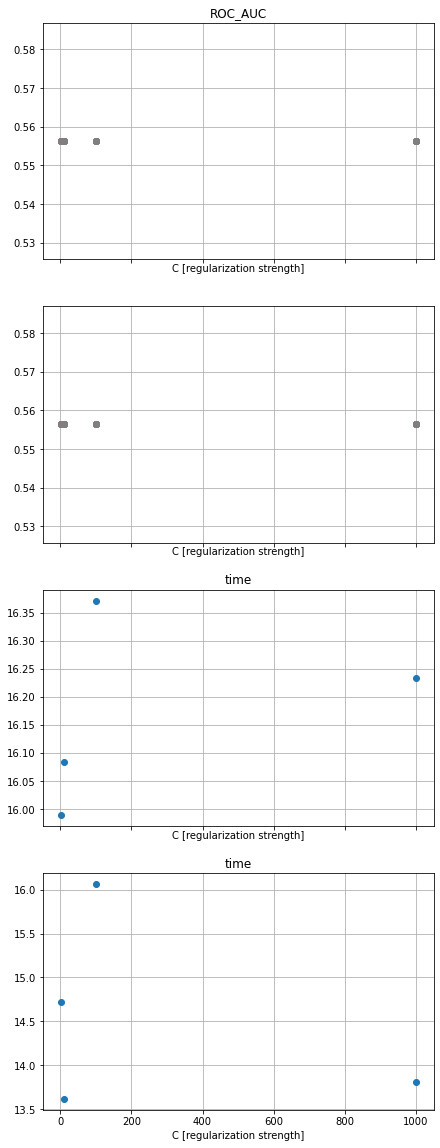

In [10]:
fig, axx = plt.subplots(4, 1, figsize = (7, 20), sharex=True)

axx[0].plot(cc, cvs1, marker = 'o',linewidth = 0)
axx[1].plot(cc, cvs2, marker = 'o', linewidth = 0)

axx[2].plot(cc, t1, marker = 'o', linewidth = 0)
axx[3].plot(cc, t2, marker = 'o', linewidth = 0)

for a in axx: 
    a.set_xlabel('C [regularization strength]')
    a.grid()
for a in axx[:1]: a.set_title('ROC_AUC')
for a in axx[2:]: a.set_title('time')

plt.savefig('log_reg.png')

In [11]:
# На предыдущем шаге мы исключили из выборки признаки rM_hero и dM_hero, которые показывают, какие именно герои играли за каждую команду. 
# Это важные признаки — герои имеют разные характеристики, и некоторые из них выигрывают чаще, чем другие. 
# Выясните из данных, сколько различных идентификаторов героев существует в данной игре (вам может пригодиться фукнция unique или value_counts).

# N — количество различных героев в выборке
N = 108
trueN = 114 #there are players id who didnt participate, zero columns in resulting matrix

# Воспользуемся подходом "мешок слов" для кодирования информации о героях. 
# Пусть всего в игре имеет N различных героев. 
# Сформируем N признаков, при этом i-й будет равен нулю, если i-й герой не участвовал в матче; единице, 
# если i-й герой играл за команду Radiant; минус единице, если i-й герой играл за команду Dire. 
# Ниже вы можете найти код, который выполняет данной преобразование. ([хуйня ваш код не работает])
# Добавьте полученные признаки к числовым, которые вы использовали во втором пункте данного этапа.

a = np.zeros((10, N))
i = 0

for f in drop_categorical[1:]:
    a[i, :] = pd.unique(features[f])
    i+=1

# missed = []
# for i in range(1, trueN): 
#     if not(i in np.sort(pd.unique(a.reshape(10*N))) ) : missed.append(i)

def transFORM(x, to_drop):
    N = 114
    X_ = np.zeros((x.shape[0], N))
    features_ = x.drop(labels = to_drop, axis = 1)
    for i, match_id in enumerate(x.index):
        for p in range(5):
            X_[i, x['r%d_hero' % (p+1)][match_id] -1] = 1
            X_[i, x['d%d_hero' % (p+1)][match_id] -1] = -1

    cols = [ 'p%d' % i for i in range(1, N+1)]

    X_plus = pd.DataFrame(X_, columns=cols, index=features_.index)

    X = pd.concat([X_plus, features_], axis=1)

    return X

In [12]:
X = transFORM(features, drop_categorical)

In [13]:
cvs3, t3 = crossV_log(X, target, cc)

1
10
100
1000


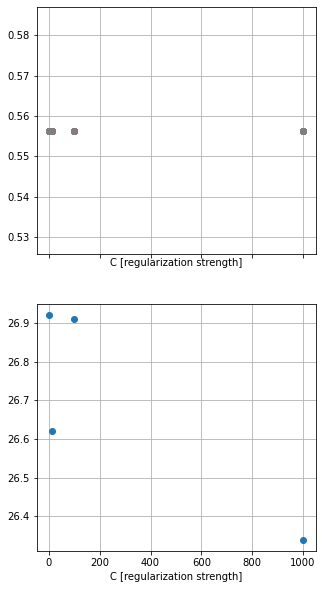

In [14]:
# 5. Проведите кросс-валидацию для логистической регрессии на новой выборке с подбором лучшего параметра регуляризации. 
# Какое получилось качество? 
# Улучшилось ли оно? 
# Чем вы можете это объяснить?
## не увеличилось оно заебись

f, a = plt.subplots(2, 1, figsize = (5, 10), sharex=True)
a[0].plot(cc, cvs3, marker = 'o',linewidth = 0)
a[1].plot(cc, t3, marker = 'o',linewidth = 0)
for a in a: 
    a.set_xlabel('C [regularization strength]')
    a.grid()

In [15]:

# Постройте предсказания вероятностей победы команды Radiant для тестовой выборки с помощью лучшей из изученных моделей 
# (лучшей с точки зрения AUC-ROC на кросс-валидации). 
# Убедитесь, что предсказанные вероятности адекватные — находятся на отрезке [0, 1], не совпадают между собой (т.е. что модель не получилась константной).

test = pd.read_csv('features_test.csv', index_col='match_id')

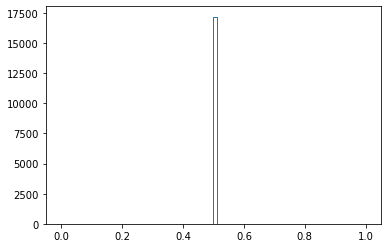

In [16]:
missing_features = test.columns[(test.count()<17177).values]
test.count()[missing_features]
for mf in missing_features:
    test[mf] = test[mf].fillna(test[mf].mean())
xx = transFORM(test, drop_categorical)
logreg = LogisticRegression(penalty='l2', C = 10, tol=1e-6)
plt.hist(logreg.fit(X, target).predict_proba(xx)[:, 0], bins = 100, histtype='step')
plt.savefig('logreg.png')

In [17]:
CVS = []
T = []
cvs = []
t = []

for n in n_est:
        CVS_tmp, T_tmp =crossV_gb(n, X, target)
        cvs_tmp, t_tmp =crossV_gb(n, features, target)
        CVS.append(CVS_tmp)
        T.append(T_tmp)
        cvs.append(cvs_tmp)
        t.append(t_tmp)

10
      Iter       Train Loss   Remaining Time 
         1           1.3728            6.37s
         2           1.3637            5.76s
         3           1.3550            5.06s
         4           1.3462            4.27s
         5           1.3383            3.52s
         6           1.3311            2.80s
         7           1.3244            2.08s
         8           1.3182            1.40s
         9           1.3130            0.70s
        10           1.3076            0.00s
      Iter       Train Loss   Remaining Time 
         1           1.3732            6.40s
         2           1.3642            5.56s
         3           1.3552            4.87s
         4           1.3465            4.19s
         5           1.3385            3.46s
         6           1.3312            2.76s
         7           1.3249            2.06s
         8           1.3194            1.37s
         9           1.3135            0.68s
        10           1.3087            0.00s
     

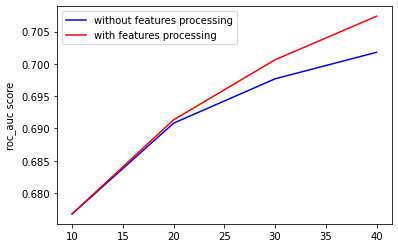

In [18]:
plt.plot(n_est, cvs, 'b', label = 'without features processing')
plt.plot(n_est, CVS, 'r', label = 'with features processing')
plt.ylabel('roc_auc score')
plt.legend()
plt.savefig('roc_auc.png')

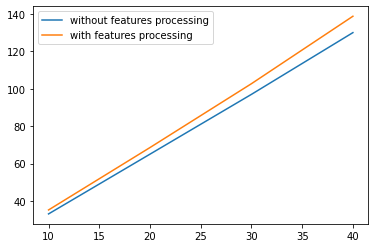

In [19]:
plt.plot(n_est, t, label = 'without features processing')
plt.plot(n_est, T, label = 'with features processing')
plt.legend()

In [20]:
n = 40
GBC = GradientBoostingClassifier(n_estimators=n, verbose=True, random_state=241, learning_rate=0.2)
P = GBC.fit(X, target).predict_proba(xx)

      Iter       Train Loss   Remaining Time 
         1           1.3735           32.47s
         2           1.3645           32.51s
         3           1.3554           31.16s
         4           1.3475           30.11s
         5           1.3394           29.15s
         6           1.3325           28.25s
         7           1.3257           27.37s
         8           1.3197           26.55s
         9           1.3141           25.70s
        10           1.3090           24.92s
        20           1.2748           16.54s
        30           1.2546            8.25s
        40           1.2400            0.00s


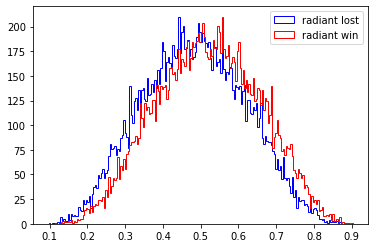

In [21]:
plt.hist(P[:,0], bins = 200, color = 'b', histtype='step', label = 'radiant lost')
plt.hist(P[:,1], bins = 200, color = 'r', histtype='step', label = 'radiant win')
GBC.classes_
plt.legend()
plt.savefig('gbc.png')